# HW 8 : Forward Filtering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

df = pd.read_csv("simdata.csv")
vy = df.values[0][1:]
mF = df.values[1:][:, 1:]
T, p = vy.shape[0], mF.shape[0]
vm0 = np.zeros((p, 1))
mC0 = 0.1*np.eye(p)
amG = [np.eye(p)]*T
amW = [0.1 * np.eye(p)]*T
vV = 0.5 * np.ones(T)

In [2]:
# prepare
    
def FF(vy, mF, vV, amG, amW, vm0, mC0):
    
    
    T, p = vy.shape[0], mF.shape[0]
    ma = np.zeros((T, p))
    mm = np.zeros((T, p))
    mb = np.zeros((T, p))
    amR = [np.eye(p)]*T
    amC = [np.eye(p)]*T
    
    
    vm = vm0
    mC = mC0
    
    # main loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:].reshape([p, 1])
            mC = amC[t-1]
            
        
        currentF = mF[:, t].reshape([1, p])
        
        ma[t, :] = np.dot(vm.T, amG[t])
        amR[t] = np.dot(np.dot(amG[t], mC), amG[t].T) + amW[t]
        dq = np.dot(np.dot(currentF, amR[t]), currentF.T) + vV[t]
        mA = np.divide(np.dot(currentF, amR[t]), dq)
        
        mm[t, :] = np.dot(vm.T, amG[t]) + np.multiply(mA, vy[t] - np.dot(currentF, np.dot(vm.T, amG[t]).T))
        amC[t] = amR[t] - np.multiply(np.dot(mA.T, mA), dq)
        
    return mm, amC

In [3]:
mm, mC = FF(vy, mF, vV, amG, amW, vm0, mC0)
b1, b2, b3, b4 = mm[:, 0], mm[:, 1], mm[:, 2] ,mm[:, 3]

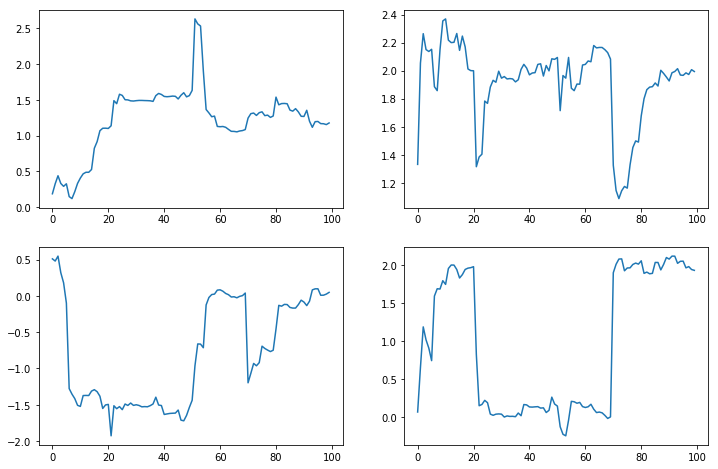

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(b1)
ax[0, 1].plot(b2)
ax[1, 0].plot(b3)
ax[1, 1].plot(b4)

# HW 9 (Q1 a): Forward Filtering and Backward Sampling 

In [5]:
def FFBS(nsim, vy, mF, vV, amG, amW, vm0, mC0):
    
    T, p = vy.shape[0], mF.shape[0]
    ma = np.zeros((T, p))
    mm = np.zeros((T, p))
    mb = np.zeros((T, p))
    amR = [np.eye(p)]*T
    amC = [np.eye(p)]*T
    amb = [0]*T
    
    vm = vm0
    mC = mC0
    
    # ff loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:].reshape([p, 1])
            mC = amC[t-1]
            
        currentF = mF[:, t].reshape([1, p])
        
        ma[t, :] = np.dot(vm.T, amG[t])
        amR[t] = np.dot(np.dot(amG[t], mC), amG[t].T) + amW[t]
        dq = np.dot(np.dot(currentF, amR[t]), currentF.T) + vV[t]
        mA = np.divide(np.dot(currentF, amR[t]), dq)
        
        m = np.dot(vm.T, amG[t]) + np.multiply(mA, vy[t] - np.dot(currentF, np.dot(vm.T, amG[t]).T))
        mm[t, :] = m
        
        C = amR[t] - np.multiply(np.dot(mA.T, mA), dq)
        amC[t] = C
    
    # BS loop
    C_float = C.astype(np.float64)
    if m.ndim == 1:
        mb = np.random.normal(m.astype(np.float64), C_float, size = nsim)
    else:
        mb = np.random.multivariate_normal(m[0].astype(np.float64), C_float, size = nsim)
        
    amb[T-1] = mb
    
    for t in reversed(range(T-1)):
        
        if m.ndim == 1:
            mB = np.dot(np.dot(amC[t], amG[t+1].T), 1/amR[t+1].astype(np.float64))
            
        else:
            mB = np.dot(np.dot(amC[t], amG[t+1].T), np.linalg.inv(amR[t+1].astype(np.float64)))
            
        mH = amC[t]- np.dot(np.dot(mB, amR[t+1]), mB.T)
        if m.ndim == 1:
            mean = mm[t, :] + (mb - ma[t, :])*mB
            
        else:
            mean = mm[t, :] + np.dot((mb - ma[t, :]), mB.T)
            
        H_float = mH.astype(np.float64)
        
        if m.ndim == 1:
            mb = mean.astype(np.float64) + np.random.normal(np.zeros(p), H_float, size = nsim)
        else:
            mb = mean.astype(np.float64) + np.random.multivariate_normal(np.zeros(p), H_float, size = nsim)
        amb[t] = mb
        
    return amb

In [6]:
nsim  = 5000
amb = FFBS(nsim, vy, mF, vV, amG, amW, vm0, mC0)

In [7]:
# aggregate

b1 = np.zeros(T)
b2 = np.zeros(T)
b3 = np.zeros(T)
b4 = np.zeros(T)
beta = [b1, b2, b3, b4]

for t in range(T-1):
    for i in range(p):
        beta[i][t] = np.mean(amb[t][:, i])

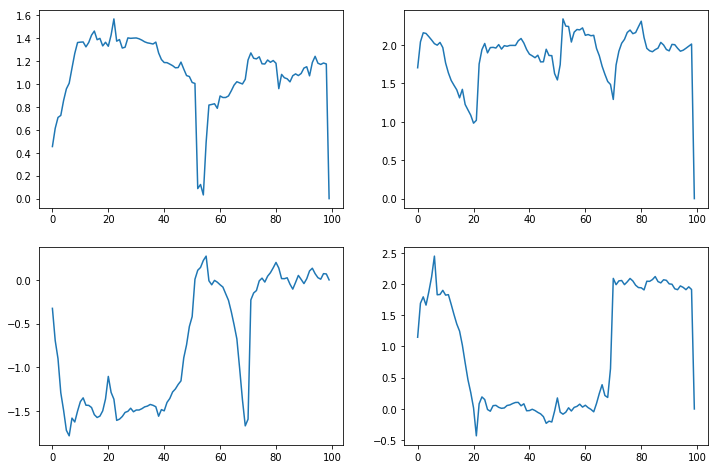

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(b1)
ax[0, 1].plot(b2)
ax[1, 0].plot(b3)
ax[1, 1].plot(b4)

# HW 9 (Q2 b) : Stochastic Volatity Model

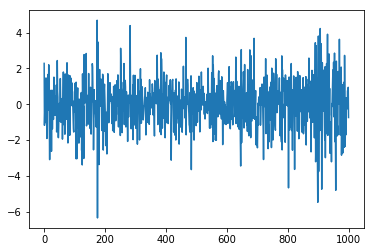

In [9]:
# data
svdata = pd.read_csv("sv_simdata.csv")
vy = svdata.values[0][1:]
plt.plot(vy)

In [10]:
# true parameters
T = vy.shape[0]
vm0 = np.array([0])
mC0 = np.array([0.1])
dmu = np.array([0])
dphi = np.array([0.95])
dsig2 = np.array([0.1])
amG = [dphi]*T
amW = [dsig2]*T

In [11]:
# approximation
vy = np.array([np.log(i**2) + 1.27 - dmu for i in vy])
vV = 2.22**2 * np.ones(T)
mF = np.ones((1, T))

In [12]:
nsim = 5000
svamb = FFBS(nsim,vy,mF,vV,amG,amW,vm0,mC0);

In [13]:
beta = np.zeros(T-1)
for t in range(T-1):
    beta[t] = np.mean(svamb[t])

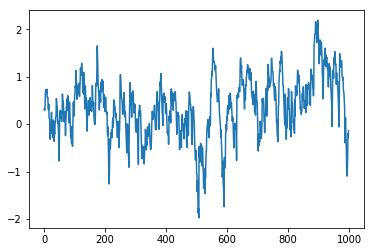

In [14]:
plt.plot(beta)

# HW 10 

In [15]:
# prepare
vy = pd.read_csv("sv_simdata.csv").values[0][1:]
nT = vy.shape[0]
vy = np.array([np.log(i**2) for i in vy])
nsim = 1
nburn = 1000
dC0 = 2

# priors
## mu
dmm = 0
dCm = 1
## phi
dmp = 0.9
dCp = 0.1
## sigma
da0 = 0.1
db0 = 0.1

# mixture setup
nK = 10
vp_mix = [0.00609, 0.04775, 0.13057,0.20674,0.22715,0.18842,0.12047,0.05591,0.01575,0.00115]
vm_mix = [1.92677,1.34744,0.73504,0.02266,-0.85173,-1.97278,-3.46788,-5.55246,-8.68384,-14.65000]
vv2_mix = [0.11265,0.17788,0.26768,0.40611,0.62699,0.98583,1.57469,2.54498,4.16591,7.33342]

# initial values
dmu = dmm + np.sqrt(dCm) * np.random.normal()
dphi = 2
dsig2 = 1/np.random.gamma(da0, db0)
vs = np.random.choice(len(vp_mix), nT, p=vp_mix)

amG = np.zeros(nT)
amW = np.zeros(nT)
mF = np.ones((1, nT))
mh = np.zeros((nsim, nT + 1))
vphi = np.zeros(nsim)
vmu = np.zeros(nsim)
vsigma = np.zeros(nsim)


In [90]:

def FFBS2(nsim, vy, mF, vV, amG, amW, vm0, mC0):
    
    
    T, p = vy.shape[0], mF.shape[0]
    ma = np.zeros((T, p))
    mm = np.zeros((T, p))
    mb = np.zeros((T, p))
    amR = [np.eye(p)]*T
    amC = [np.eye(p)]*T
    amb = [0]*(T+1)
    
    vm = vm0
    mC = mC0
    
    # ff loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:].reshape([p, 1])
            mC = amC[t-1]
            
        currentF = mF[:, t].reshape([1, p])
        
        
        ma[t, :] = np.dot(vm.T, amG[t])
        amR[t] = np.dot(np.dot(amG[t], mC), amG[t].T) + amW[t]
        dq = np.dot(np.dot(currentF, amR[t]), currentF.T) + vV[t]
        mA = np.divide(np.dot(currentF, amR[t]), dq)
        
        m = np.dot(vm.T, amG[t]) + np.multiply(mA, vy[t] - np.dot(currentF, np.dot(vm.T, amG[t]).T))
        mm[t, :] = m
        
        C = amR[t] - np.multiply(np.dot(mA.T, mA), dq)
        amC[t] = C
    
    # BS loop
    C_float = C.astype(np.float64)
    if m.ndim == 1:
        mb = np.random.normal(m.astype(np.float64), C_float, size = nsim)
    else:
        mb = np.random.multivariate_normal(m[0].astype(np.float64), C_float, size = nsim)
        
    m = m[0]
    amb[T] = mb
    
    for t in reversed(range(T)):
        
        if m.ndim == 1:
            mB = np.dot(np.dot(amC[t], amG[t].T), 1/amR[t].astype(np.float64))
            
        else:
            mB = np.dot(np.dot(amC[t], amG[t].T), np.linalg.inv(amR[t].astype(np.float64)))
            
        mH = amC[t]- np.dot(np.dot(mB, amR[t]), mB.T)
        if m.ndim == 1:
            mean = mm[t, :] + (mb - ma[t, :])*mB
            
        else:
            mean = mm[t, :] + np.dot((mb - ma[t, :]), mB.T)
            
        H_float = mH.astype(np.float64)
        
        if m.ndim == 1:
            mb = mean.astype(np.float64) + np.random.normal(0, H_float[0][0], size = nsim)
        else:
            mb = mean.astype(np.float64) + np.random.multivariate_normal(np.zeros(p), H_float, size = nsim)
        amb[t] = mb
        
    return amb

In [95]:
# MCMC
for i in range(nsim):
    
    # FFBS part
    vy_star = vy - dmu - np.array([vm_mix[j] for j in vs])
    vV = np.array([vv2_mix[j] for j in vs])
    amG[:] = dphi
    amW[:] = dsig2
    vh_star = FFBS2(1,vy_star,mF,vV,amG,amW, np.array([0]) ,dC0 + dsig2)
    
    # sampling phi
    alpha = (np.sum([vh_star[i][0][0]**2 for i in range(1,nT)]) - 2*np.sum([vh_star[i][0][0]*vh_star[i-1][0][0] for i in range(1, nT+1)]))/(2*vh_star[0]**2)
    beta2 = dsig2/(2*vh_star[0]**2)
    dC = (alpha * dCp + dmp * beta2)/(beta2 + dCp)
    dm = beta2*dCp/(beta2 + dCp)
    phi = np.random.normal(loc = dm, scale = dC)[0][0]
    

2.399031958105587


In [67]:
[i for i in range(1,5)]

[1, 2, 3, 4]

In [33]:
np.array([vv2_mix[j] for j in vs])

array([0.40611, 0.98583, 0.40611, 0.40611, 0.26768, 0.98583, 0.98583,
       0.40611, 0.98583, 0.98583, 1.57469, 0.40611, 0.40611, 0.98583,
       0.62699, 0.17788, 1.57469, 1.57469, 0.98583, 0.62699, 0.98583,
       0.62699, 0.62699, 0.40611, 0.62699, 0.26768, 0.62699, 0.98583,
       0.98583, 0.98583, 0.40611, 0.17788, 0.40611, 0.62699, 2.54498,
       0.40611, 0.98583, 0.40611, 0.40611, 2.54498, 0.62699, 2.54498,
       0.40611, 1.57469, 0.26768, 0.17788, 1.57469, 0.62699, 0.62699,
       0.62699, 1.57469, 0.40611, 1.57469, 0.40611, 0.26768, 1.57469,
       0.40611, 1.57469, 0.62699, 0.98583, 0.40611, 0.98583, 0.40611,
       0.62699, 0.62699, 0.17788, 0.62699, 1.57469, 1.57469, 2.54498,
       0.26768, 0.26768, 0.26768, 0.62699, 0.40611, 2.54498, 0.98583,
       0.40611, 1.57469, 0.26768, 1.57469, 0.98583, 0.17788, 0.40611,
       0.40611, 0.62699, 1.57469, 0.40611, 2.54498, 0.62699, 0.98583,
       0.98583, 0.40611, 0.40611, 0.40611, 0.98583, 0.17788, 0.17788,
       0.62699, 0.40

In [31]:
vy 

array([ 1.64664245e+00,  3.30790909e-01, -1.73892373e+00, -3.47924151e+00,
       -3.64725240e-01,  5.56232721e-02,  7.64926112e-01, -8.00456116e-01,
       -6.25024221e-01,  1.29860889e+00, -6.57525352e-01, -7.15336339e-01,
        1.01230550e+00, -3.58662628e-01, -2.14507393e+00,  1.57690927e+00,
       -1.00294081e+00, -1.25643294e+00,  2.26010608e+00, -2.17799352e+00,
       -3.03761351e+00, -2.58867664e+00, -5.11976529e-01, -5.51288176e+00,
        1.92996577e+00, -2.27332726e+00, -4.95992001e-01,  6.37146960e-01,
       -4.27467773e+00, -1.89453263e+00, -3.29858689e-01, -3.72470633e-01,
        8.22734970e-01, -3.43233694e+00, -1.44841753e+00, -3.90020431e+00,
       -9.41309228e-01, -1.99468838e+00, -1.09467153e+00, -4.12513999e+00,
        1.43837065e-01,  8.76469106e-01, -1.14394435e+00,  1.78019287e+00,
       -6.60300703e-01, -1.84661520e+00,  1.23348955e+00,  1.24801328e+00,
       -5.92813656e-01, -7.30923488e+00, -5.84344297e+00, -1.03638266e-01,
       -1.88730564e+00,  

In [36]:
a = np.zeros(4)
a[:] = 8

In [37]:
a

array([8., 8., 8., 8.])